In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.datasets import fetch_openml
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class Discriminator(nn.Module):
    def __init__(self, img_dim, target_dim):
        super().__init__()
        self.disc = nn.Sequential(
        nn.Linear(img_dim + target_dim, 512),
        nn.LeakyReLU(0.1),
        nn.Linear(512,1),
        nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.disc(x)

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim, target_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim + target_dim, 512),
            #nn.ReLU(),
            nn.LeakyReLU(0.1),
            nn.Linear(512, img_dim),
            nn.Tanh(),
            #nn.Sigmoid(),
            #nn.LeakyReLU(0.1),
        )
    def forward(self, x):
            return self.gen(x)

In [5]:
def disc_criterion(disc_real, disc_fake):
    return -torch.mean(torch.log(disc_real + 1e-10) + torch.log(1 - disc_fake + 1e-10))

In [6]:
def gen_criterion2(disc_fake):
    return -torch.mean(torch.log(disc_fake + 1e-10))

In [7]:
def gen_criterion(disc_fake):
    return -torch.mean(torch.log(disc_fake + 1e-10))

In [8]:
def ms_criterion(noise, noise2, fake, fake2):
    return 1/(torch.mean(torch.abs(fake - fake2)) / torch.mean(torch.abs(noise - noise2)) + 1e-5)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 100
image_dim = 28 * 28 * 1
batch_size = 128
num_epochs = 300
target_dim = 10

In [29]:
disc = Discriminator(image_dim, target_dim).to(device)
gen = Generator(z_dim, image_dim, target_dim).to(device)

In [30]:
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]
)

AttributeError: 'Compose' object has no attribute 'Compose'

In [31]:
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [32]:
opt_disc = optim.Adam(disc.parameters(), lr=9e-5)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

In [33]:
mnist = fetch_openml('mnist_784')
X = (mnist.data>127.5)*1.0
T = mnist.target

(70000, 784) (70000,)


In [35]:
def myDataLoader(data, T, batch_size):

    size = len(data)
    batches = []
    targets = []
    R = np.random.permutation(size)
    data_shuffle = data[R,:]
    targets_shuffle = T[R]
    targets_shuffle = [int(n) for n in targets_shuffle]
    
    targets_shuffle = [np.eye(1,10,n) for n in targets_shuffle]
    
    
    for i in range(size // batch_size):
        batches += [data_shuffle[batch_size * i : (i + 1) * batch_size, :]]
        targets += [targets_shuffle[batch_size * i : (i + 1) * batch_size]]
        
        
    batches = torch.tensor(batches, dtype=torch.float32)
    targets = torch.tensor(targets, dtype=torch.float32)
        
    return batches, targets

In [36]:
def get_target(batch_size):
    target = []
    for _ in range(batch_size):
        target += [np.eye(1,10,int((torch.rand(1) * 10).round()))]
        
    return torch.tensor(target, dtype=torch.float32)

def get_target_number(batch_size, n):
    target = []
    for _ in range(batch_size):
        target += [np.eye(1,10,n)]
        
    return torch.tensor(target, dtype=torch.float32)

def get_target_1hot(batch_size, rtarget):
    target = []
    for i in range(batch_size):
        target += [np.eye(1,10,rtarget[i].item())]
        
    return torch.tensor(target, dtype=torch.float32)

In [37]:
def get_batch(data, batch_size):
    R = np.random.permutation(len(data))
    Rtrain = R[:batch_size]
    Xtrain = data[Rtrain,:]
    return torch.tensor(Xtrain, dtype=torch.float32)

In [23]:
#MODE SEEKING GAN
for epoch in range(num_epochs):
    for batch_idx, (real, rtarget) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]
        real_target = get_target_1hot(batch_size, rtarget)
        real = torch.cat((real, real_target.view(batch_size,-1)), dim=1)
        for _ in range(2):
        
            noise = torch.randn(batch_size, z_dim).to(device)
            noise2 = torch.randn(batch_size, z_dim)
            fake_target = get_target(batch_size)
            noise_t = torch.cat((noise, fake_target.view(batch_size,-1)), dim=1)
            noise_t2 = torch.cat((noise2, fake_target.view(batch_size,-1)), dim=1)
        
            fake = gen(noise_t)
            fake2 = gen(noise_t2)
            fake_t = torch.cat((fake, fake_target.view(batch_size,-1)), dim=1)
                        
            disc_real = disc(real).view(-1)
            disc_fake = disc(fake_t).view(-1)
        
            lossD = disc_criterion(disc_real, disc_fake)
            disc.zero_grad()
            lossD.backward(retain_graph=True)
            opt_disc.step()

        output = disc(fake_t).view(-1)
        lossG = gen_criterion(output) + ms_criterion(noise, noise2, fake, fake2)
        
        gen.zero_grad()

        lossG.backward()
        opt_gen.step()
        if batch_idx >= 60000 // batch_size-1:
            print("epoch:", epoch, "real:", torch.mean(disc(real)).detach().numpy(), "fake:", torch.mean(disc(fake_t)).detach().numpy())

epoch: 0 real: 0.83597964 fake: 0.17724328
epoch: 1 real: 0.80327374 fake: 0.14618188
epoch: 2 real: 0.852828 fake: 0.14026022
epoch: 3 real: 0.8201016 fake: 0.20869412
epoch: 4 real: 0.781777 fake: 0.16916674
epoch: 5 real: 0.8070354 fake: 0.16821407
epoch: 6 real: 0.8153707 fake: 0.20520341
epoch: 7 real: 0.7545754 fake: 0.25727585
epoch: 8 real: 0.80813986 fake: 0.14198187
epoch: 9 real: 0.75791156 fake: 0.24088635
epoch: 10 real: 0.7339057 fake: 0.25265357
epoch: 11 real: 0.7489061 fake: 0.19942391
epoch: 12 real: 0.74064124 fake: 0.25300398
epoch: 13 real: 0.7539623 fake: 0.28968465
epoch: 14 real: 0.7628461 fake: 0.26960775
epoch: 15 real: 0.7553029 fake: 0.28533113
epoch: 16 real: 0.7770523 fake: 0.26267904
epoch: 17 real: 0.7309059 fake: 0.25572142
epoch: 18 real: 0.8104886 fake: 0.22027232
epoch: 19 real: 0.70647025 fake: 0.2173079
epoch: 20 real: 0.7052716 fake: 0.22260872
epoch: 21 real: 0.77998215 fake: 0.2197387
epoch: 22 real: 0.7105404 fake: 0.27287537
epoch: 23 real: 0.

epoch: 189 real: 0.7806647 fake: 0.3096149
epoch: 190 real: 0.70116156 fake: 0.24172497
epoch: 191 real: 0.71431994 fake: 0.21458875
epoch: 192 real: 0.7638862 fake: 0.29660693
epoch: 193 real: 0.72023344 fake: 0.27973112
epoch: 194 real: 0.76833606 fake: 0.32744038
epoch: 195 real: 0.71780115 fake: 0.22910507
epoch: 196 real: 0.74878484 fake: 0.30027905
epoch: 197 real: 0.8011214 fake: 0.32516995
epoch: 198 real: 0.77126676 fake: 0.38754025
epoch: 199 real: 0.7076195 fake: 0.2742609
epoch: 200 real: 0.7178221 fake: 0.28903562
epoch: 201 real: 0.76850367 fake: 0.30564183
epoch: 202 real: 0.63576746 fake: 0.2120857
epoch: 203 real: 0.7824225 fake: 0.38201737
epoch: 204 real: 0.7422009 fake: 0.31773064
epoch: 205 real: 0.65276253 fake: 0.21223328
epoch: 206 real: 0.6257706 fake: 0.20558476
epoch: 207 real: 0.69565535 fake: 0.25756866
epoch: 208 real: 0.7180844 fake: 0.23958531
epoch: 209 real: 0.6922948 fake: 0.2142156
epoch: 210 real: 0.7389329 fake: 0.32732463
epoch: 211 real: 0.733860

In [19]:
losses_d = []
losses_g = []

In [38]:
#VANILLA GAN
for epoch in range(num_epochs):
    for batch_idx, (real, rtarget) in enumerate(loader):
        real = real.view(-1, 784).to(device)


        batch_size = real.shape[0]
        real_target = get_target_1hot(batch_size, rtarget)
        real = torch.cat((real, real_target.view(batch_size,-1)), dim=1)
        for _ in range(5):
        
            noise = torch.randn(batch_size, z_dim).to(device)
            fake_target = get_target(batch_size)
            noise_t = torch.cat((noise, fake_target.view(batch_size,-1)), dim=1)
        
            fake = gen(noise_t)
            fake_t = torch.cat((fake, fake_target.view(batch_size,-1)), dim=1)
                        
            disc_real = disc(real).view(-1)
            disc_fake = disc(fake_t).view(-1)
        
            lossD = disc_criterion(disc_real, disc_fake)
            losses_d += [lossD.detach().numpy()]
            disc.zero_grad()
            lossD.backward(retain_graph=True)
            opt_disc.step()

        output = disc(fake_t).view(-1)
        lossG = gen_criterion(output)
        losses_g += [lossG.detach().numpy()]
        gen.zero_grad()

        lossG.backward()
        opt_gen.step()
        if batch_idx >= 60000 // batch_size-1:
            print("epoch:", epoch, "real:", torch.mean(disc(real)).detach().numpy(), "fake:", torch.mean(disc(fake_t)).detach().numpy())

KeyboardInterrupt: 

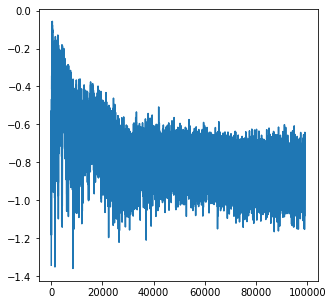

In [27]:
plt.figure(figsize=(5,5))
plt.plot([-l for l in losses_d])
plt.savefig('lossplot', bbox_inches='tight')

In [24]:
def render(x,w,h,vmax=0.1):
    x = x.reshape([h,w,28,28])
    z = np.ones([h,w,30,30])*vmax
    z[:,:,1:-1,1:-1] = x
    x = z.reshape([h,w,30,30]).transpose([0,2,1,3]).reshape([h*30,w*30])
    plt.figure(figsize=(0.3*2*w,0.3*2*h))
    plt.imshow(x,cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

torch.Size([10, 784]) www
torch.Size([10, 784]) www
torch.Size([10, 784]) www
torch.Size([10, 784]) www
torch.Size([10, 784]) www
torch.Size([10, 784]) www
torch.Size([10, 784]) www
torch.Size([10, 784]) www
torch.Size([10, 784]) www
torch.Size([10, 784]) www
torch.Size([100, 28, 28]) erre
100


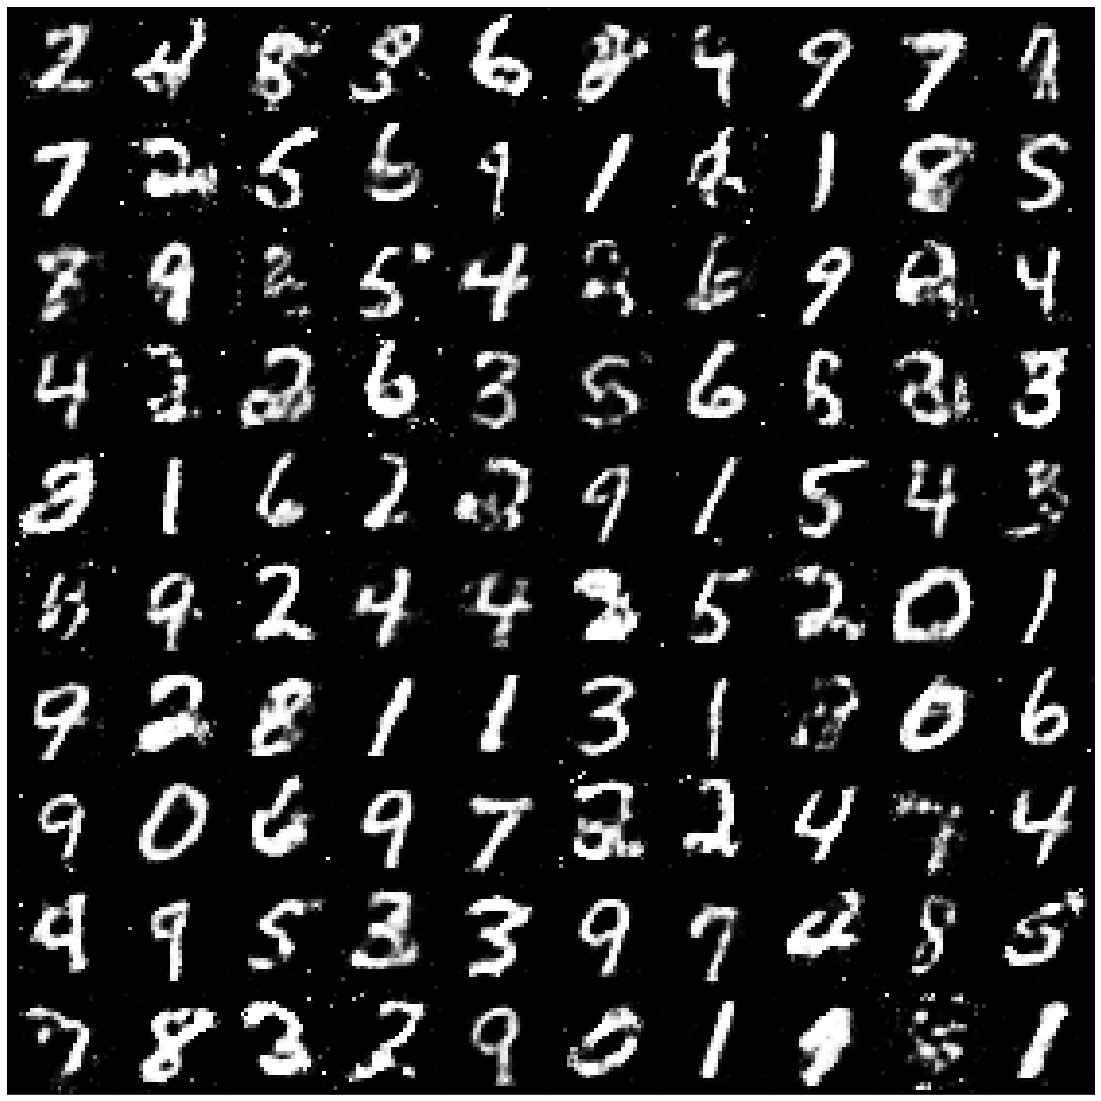

NameError: name 'out' is not defined

In [28]:
batch_size = 10
gene = gen.eval()
outs = []
outt = torch.tensor(np.zeros((10,28,28)), dtype=torch.float32)
for target in np.arange(10):
    with torch.no_grad():
        rand_target = get_target(batch_size).view(batch_size, -1)
        z = torch.cat((torch.randn(batch_size, z_dim), rand_target ), dim=1)
        out_for = gene(z)

        outt = torch.cat((outt, out_for.reshape(-1,28,28)), 0)
outt = outt[10:]
for i in range(outt.shape[0]):
    outs += [outt[i]]
fig = plt.figure(figsize=(20,20))        
grid = ImageGrid(fig,111,  
         nrows_ncols=(10, 10), 
         axes_pad=0, 
         )
for ax, im in zip(grid, outs):
    ax.tick_params(
    axis='both',         
    which='both',     
    bottom=False,     
    top=False,
    left=False,
    labelbottom=False,
    labelleft=False)
    for i in np.arange(batch_size):
        ax.imshow(im, cmap=plt.cm.gray)
plt.savefig('gen_cond_mnist3.png', bbox_inches='tight')
plt.show()
    
rand_target = get_target(batch_size).view(batch_size, -1)
target_n = get_target_number(batch_size, 0).view(batch_size, -1)
z = torch.cat((torch.randn(batch_size, z_dim), target_n ), dim=1)